In [45]:
import yfinance as yf
from src import meanReversionTest
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

importlib.reload(meanReversionTest)

<module 'src.meanReversionTest' from 'c:\\Users\\jnche\\Desktop\\Personal Projects\\algotrade\\project1_meanReversion\\src\\meanReversionTest.py'>

Download the specified price data using yfinance.

In [46]:
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2015-01-01', end='2024-01-01', auto_adjust=False)
print(data['Adj Close'].head())
adjCloseData = data['Adj Close']

[*********************100%***********************]  2 of 2 completed

Ticker           AAPL       MSFT
Date                            
2015-01-02  24.237551  39.858444
2015-01-05  23.554741  39.491920
2015-01-06  23.556961  38.912281
2015-01-07  23.887281  39.406677
2015-01-08  24.805077  40.565956


Using simple visualization techniques, see if the selected tickers might currentcurrentcurrentcurrentcurrentPositionitionitionitionitionsibly be cointegrable.

In the price series plot, we are looking for the tickers to "mirror" each other.

In the scatter plot, we are looking for a relatively linear relationship.

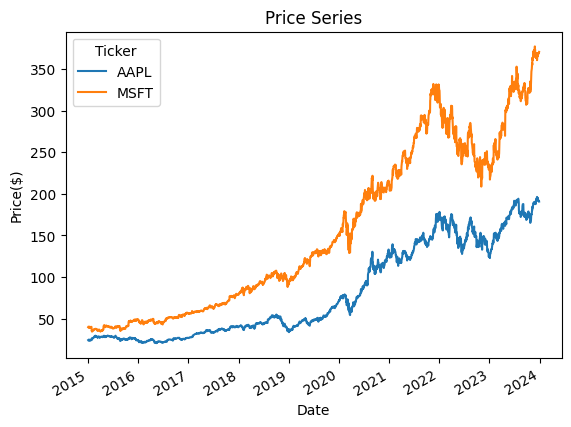

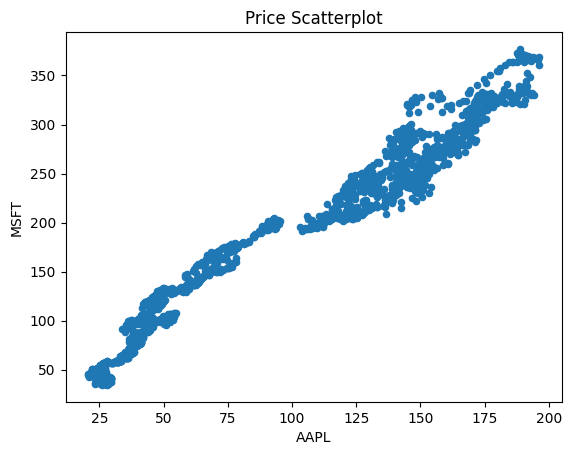

In [47]:
meanReversionTest.plotPriceSeries(adjCloseData)
meanReversionTest.plotScatterSeries(adjCloseData)

Now, we run the CADF test.

First, we fit a linear model to the scatter plot of the two price series.
* This gives us the residuals, along with some other information.
* The residuals are the distance between the predictions of our linear model (using the price series that we set as the independent variable), and the actual price (the other price series that we set as the dependent variable)
* Here, we just choose the price series in the first column of adjCloseData to be the independent variable.

We can plot the residuals to see if, visually, they look like they might be mean reverting.

Finally, we run ADF on the residuals to test if the residuals actually are mean reverting.

c:\Users\jnche\Desktop\Personal Projects\algotrade\project1_meanReversion\src\meanReversionTest.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Residuals'] = res.resid


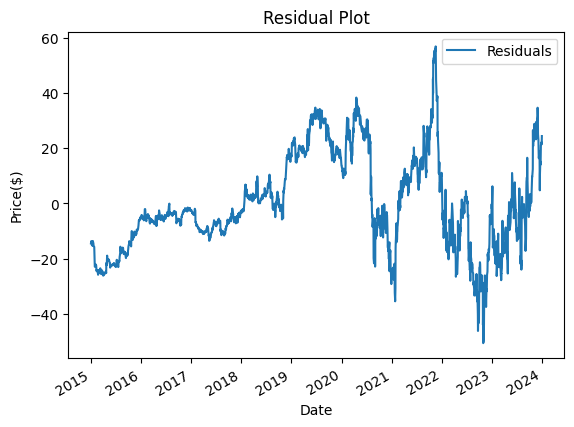

Test statistic: -2.746985318016396
p value: 0.06625462925938574


In [48]:
adjCloseData, beta, intercept = meanReversionTest.fitLinearModel(adjCloseData)
meanReversionTest.plotResiduals(adjCloseData)
testStatistic, pValue, criticalValues = meanReversionTest.doCadf(adjCloseData)

If we determine, based on the test statistic and the p value, that the two price series are cointegrable, we can now specify a linear mean reverting trading strategy and backtest.

First, we calculate the z-score of the spreads/residuals.

In [49]:
spread = adjCloseData['Residuals']
spread = spread.to_numpy()
zscore = (spread - spread.mean()) / spread.std()
print(zscore[:5])

[-0.83377075 -0.78597299 -0.81956888 -0.82443617 -0.85030375]


Then, we backtest.

In [50]:
def calculatePnL(typ: str, entrySpread: float, exitSpread: float) -> float:
    '''
    Calculates the profit and loss based on the current position
    '''
    if typ == 'short':
        return entrySpread - exitSpread # here, we sell high, buy low
    elif typ == 'long':
        return exitSpread - entrySpread # here, we buy low, sell high
    else:
        print(f'ERROR: unexpected type of {typ}.')
        return 0

allPositions = []
currentPosition = None # hold only one position at a time
cumulativePnL = pd.DataFrame(columns=['Time', 'Cumulative PnL'])
cumulativePnL.loc[0] = [0, 0]
portfolioValue = 0

for t in range(len(zscore)):
    # calculate cumulative PnL
    '''
    dailyPnl = 0
    for pos in currentPositions:
        direction = 1 if pos['type'] == 'long' else -1
        dailyPnl += direction * (spread[t] - spread[t - 1])
    newRow = pd.DataFrame([{'Time': t, 'Cumulative PnL': cumulativePnL.iloc[-1]['Cumulative PnL'] + dailyPnl}])
    cumulativePnL = pd.concat([cumulativePnL, newRow], ignore_index=True)
    '''

    if currentPosition is None:
        # we can enter, depending on the signal
        if zscore[t] > 2:
            # short
            currentPosition = {'type': 'short', 'enterTime': t, 'enterSpread': spread[t]}
        elif zscore[t] < -2:
            # long
            currentPositions = {'type': 'long', 'enterTime': t, 'enterSpread': spread[t]}
    else:
        if abs(zscore[t]) < 0.5:
            # exit positions, but only if we actually hold any
            currentPosition['exitTime'] = t
            currentPosition['exitSpread'] = spread[t]
            currentPosition['profit'] = calculatePnL(currentPosition['type'], currentPosition['enterSpread'], currentPosition['exitSpread'])
            portfolioValue += currentPosition['profit']
            print(currentPosition['profit'])
            currentPosition['portfolioValue'] = portfolioValue
            allPositions.append(currentPosition)
            currentPosition = None

print(portfolioValue)

31.958698687910584
38.539008712013185
70.49770739992377


Evaluate performance using:
* Equity curve (cumulative PnL)
* Sharpe ratio
* Max Drawdown
* Number of trades / win rate

In [51]:
'''
fig = cumulativePnL.plot(x = 'Time', y = 'Cumulative PnL', title="Cumulative PnL")
fig.set_ylabel("Cumulative PnL")
plt.show()
'''

'\nfig = cumulativePnL.plot(x = \'Time\', y = \'Cumulative PnL\', title="Cumulative PnL")\nfig.set_ylabel("Cumulative PnL")\nplt.show()\n'